# Fips Aggregation

## Packages

In [10]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dask
import os
import glob
import geopandas as gpd
import xagg as xa

## Inputs

In [11]:
model = "NOAH"
county_shp_path = "/storage/work/cta5244/avila_et_al_2025_pyWBM_yield/shape_files/counties_contig_plot.shp"
binned_edd_path = f"/storage/home/cta5244/work/pyWBM_yield_data/{model}_edd_bins/"
dday_base_path = "/storage/home/cta5244/work/pyWBM_yield_data/NCEPNARR_NLDAS_tmax_tmin/"
sm_base_path = f"/storage/home/cta5244/work/pyWBM_yield_data/{model}_daily/"
filepath_save_sm_mean = f"/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/{model}_seasonal_average_alltime_average_soilmoisture.nc"
start_year, end_year, start_month, end_month = 1979, 2025, 4, 9
output_gdd_path = f"/storage/home/cta5244/work/pyWBM_yield_data/{model}_gdd_bins/"
output_soilm_path = f"/storage/home/cta5244/work/pyWBM_yield_data/{model}_yearly_average/"

## Processing gdd

In [12]:
# aggregate gdd to yearly
def process_gdd(year):
    '''
    simply processes gdd to make it yearly, & sums it
    '''
    dday_new_path = f"{dday_base_path}{year}"
    single_year_gdd = []
    for month in np.arange(start_month, end_month + 1):
        dday_yearly_patterns = sorted(glob.glob(f"{dday_new_path}/NLDAS_FORA0125_H.A{year}{str(month).zfill(2)}*_dday.nc"))
        for file_i in dday_yearly_patterns:
            single_year_gdd.append(file_i)
            
    single_year_gdd_ds = xr.concat([xr.open_dataset(f) for f in single_year_gdd], dim="time")
    single_year_gdd_ds = single_year_gdd_ds.gdd.sum('time')
    single_year_gdd_ds.to_netcdf(f"{output_gdd_path}NLDAS_FORA0125_{model}_H.A{year}_binned_gdd.nc")

In [3]:
### dask delayed
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    memory="3GiB",
    walltime="01:00:00",
)

cluster.scale(jobs=45) 


/storage/home/cta5244/mambaforge/envs/pyWBM/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44995 instead
  warnings.warn(


In [13]:
from dask.distributed import Client

client = Client(cluster)
client

<Client: 'tcp://146.186.150.14:34599' processes=45 threads=45, memory=135.00 GiB>

In [14]:
os.makedirs(output_gdd_path, exist_ok=True)
results = []
for year in np.arange(start_year, end_year):
    out = dask.delayed(process_gdd)(year=year)
    results.append(out)

results = dask.compute(*results)

## Processing soil moisture

In [15]:
def process_soilm(year):
    '''
    simply processes gdd to make it yearly, & averages it
    '''
    sm_new_path = f"{sm_base_path}{year}"
    single_year_sm = []
    for month in np.arange(start_month, end_month + 1):
        sm_yearly_patterns = sorted(glob.glob(f"{sm_new_path}/NLDAS_{model}0125_H.A{year}{str(month).zfill(2)}*.nc"))
        for file_i in sm_yearly_patterns:
            single_year_sm.append(file_i)
            
    single_year_sm_ds = xr.concat([xr.open_dataset(f) for f in single_year_sm], dim="time")
    single_year_sm_ds = single_year_sm_ds.SoilM_0_100cm.mean('time')
    single_year_sm_ds.to_netcdf(f"{output_soilm_path}NLDAS_{model}0125_H.A{year}_sm_avg.nc")

In [16]:
os.makedirs(output_soilm_path, exist_ok=True)
results = []
for year in np.arange(start_year, end_year):
    out = dask.delayed(process_soilm)(year=year)
    results.append(out)

results = dask.compute(*results)

## Now put it together to fips level !

In [17]:
# binned edd already processed
binned_edd_patterns = sorted(glob.glob(f"{binned_edd_path}*"))
binned_edd_ds = xr.concat([xr.open_dataset(f) for f in binned_edd_patterns], dim="time")
gdd_patterns = sorted(glob.glob(f"{output_gdd_path}*"))
soilm_patterns = sorted(glob.glob(f"{output_soilm_path}*"))

combined_dataset = xr.Dataset({
            "SoilM_0_100cm": xr.concat([xr.open_dataset(f) for f in soilm_patterns], dim="time").SoilM_0_100cm,
            "gdd": xr.concat([xr.open_dataset(f) for f in gdd_patterns], dim="time").gdd,
            "edd_plus75": binned_edd_ds.edd_plus75,
            "edd_plus25_75": binned_edd_ds.edd_plus25_75,
            "edd_minus25_plus25": binned_edd_ds.edd_minus25_plus25,
            "edd_minus25_75": binned_edd_ds.edd_minus25_75,
            "edd_minus75": binned_edd_ds.edd_minus75
             })

In [18]:
us_county = gpd.read_file(county_shp_path)
us_county = us_county.to_crs("EPSG:4326")
weightmap = xa.pixel_overlaps(combined_dataset, us_county)
aggregated = xa.aggregate(combined_dataset, weightmap)

ds_out = aggregated.to_dataset().to_dataframe()
ds_out = ds_out.reset_index().set_index(['fips','time'])


creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
adjusting grid... (this may happen because only a subset of pixels were used for aggregation for efficiency - i.e. [subset_bbox=True] in xa.pixel_overlaps())
grid adjustment successful
aggregating SoilM_0_100cm...
aggregating gdd...
aggregating edd_plus75...
aggregating edd_plus25_75...
aggregating edd_minus25_plus25...
aggregating edd_minus25_75...
aggregating edd_minus75...
all variables aggregated to polygons!


In [19]:
ds_out['SoilM_0_100cm_square'] = ds_out['SoilM_0_100cm'] ** 2
ds_out.index = ds_out.index.set_levels(pd.Index(range(1979, 2025)), level='time')

In [20]:
csv_output_file_haqiqi2021_2a = f"/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/{model}_csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"
ds_out.to_csv(csv_output_file_haqiqi2021_2a, index=True)

#### Some exploratory plotting for average inputs

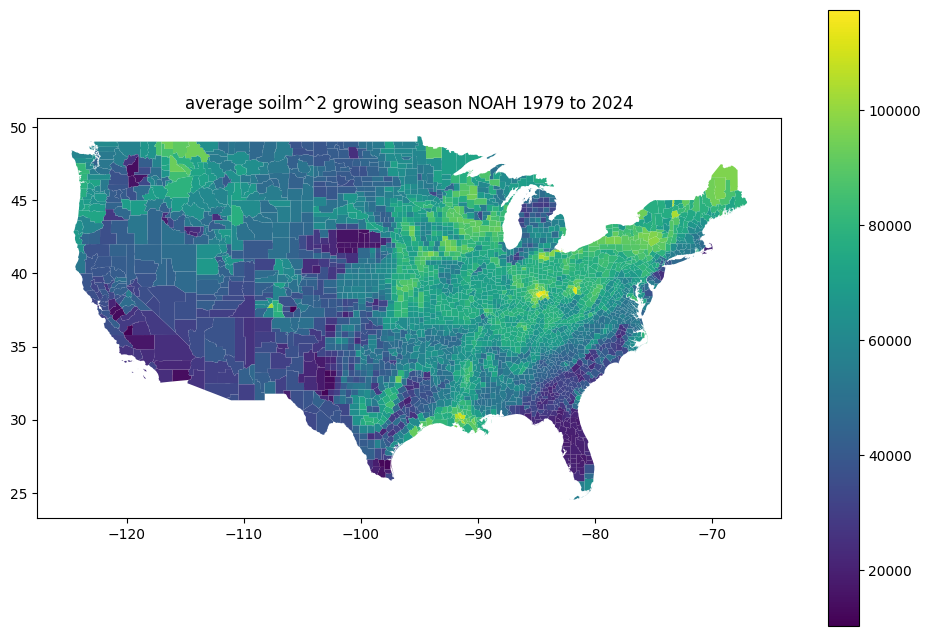

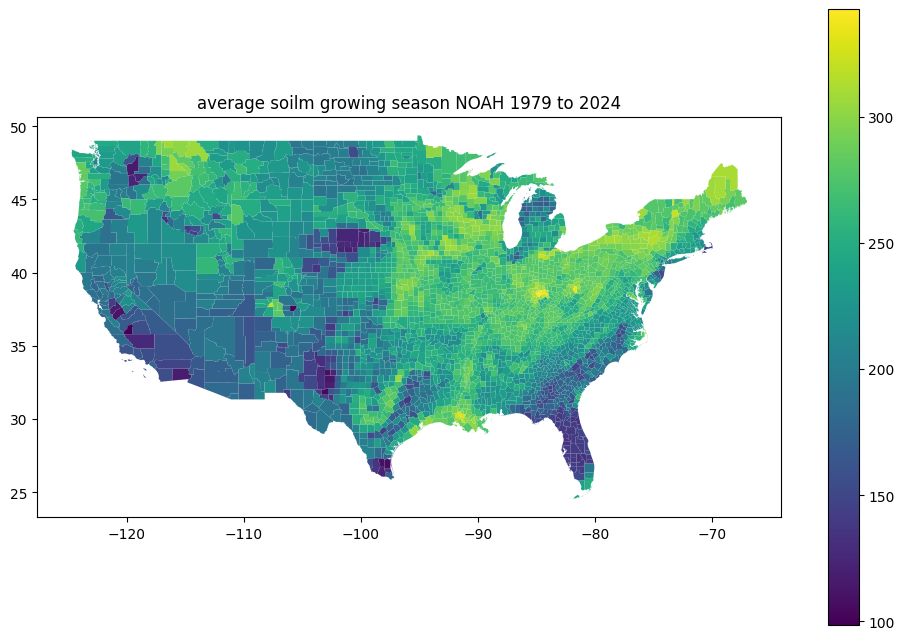

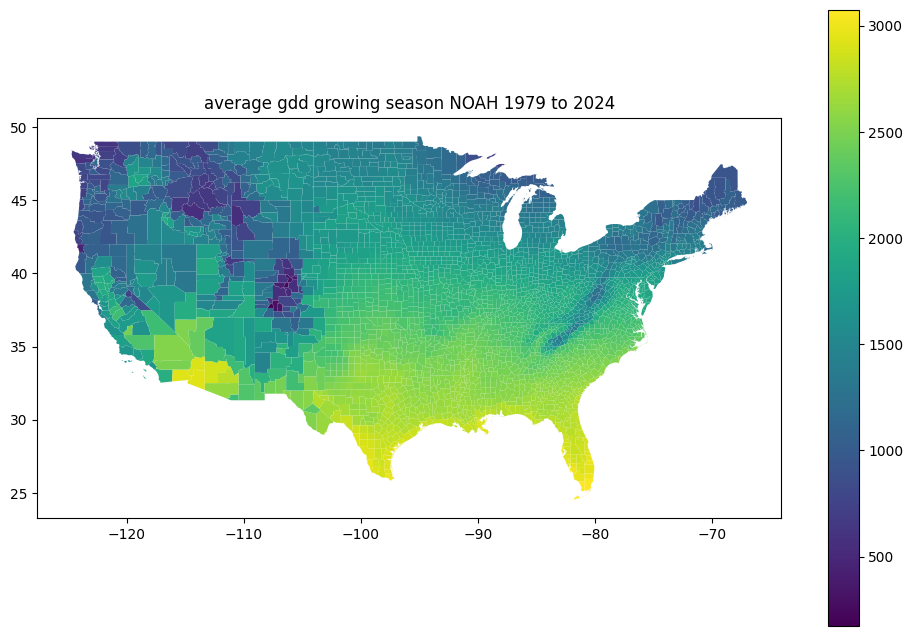

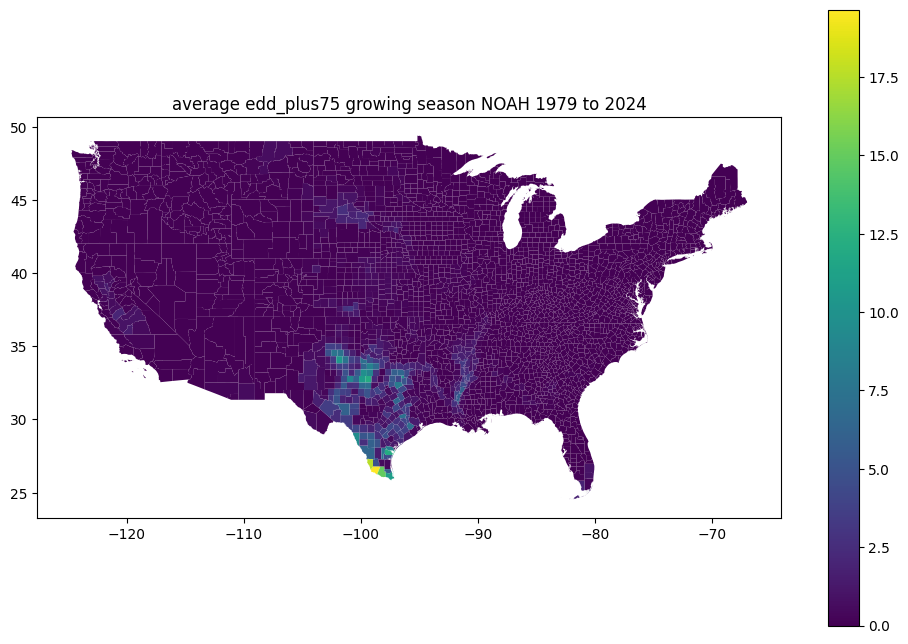

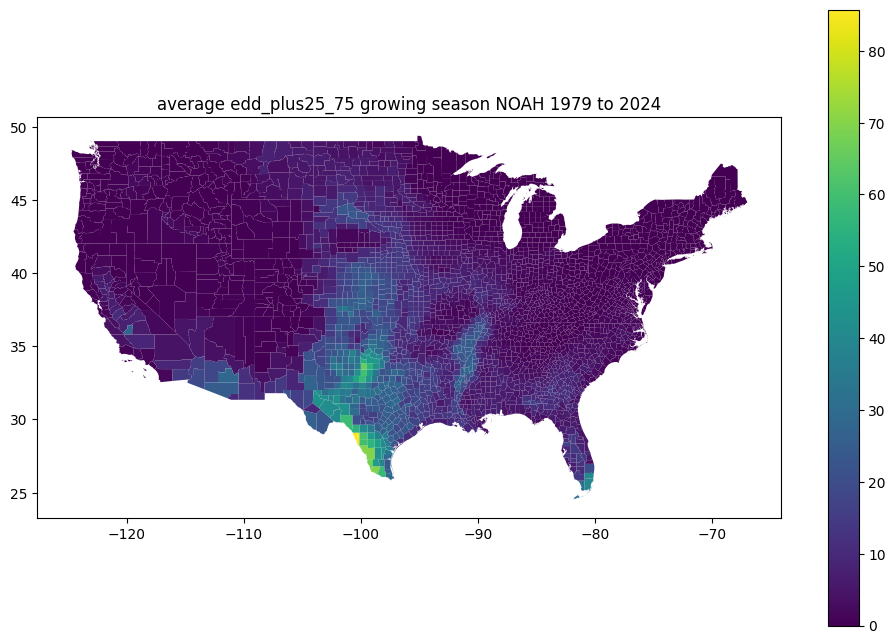

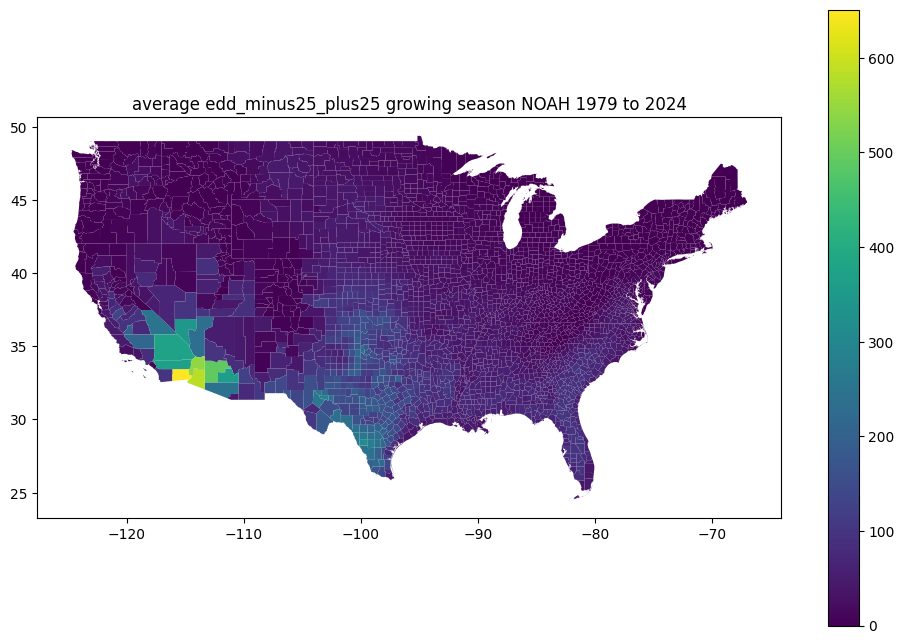

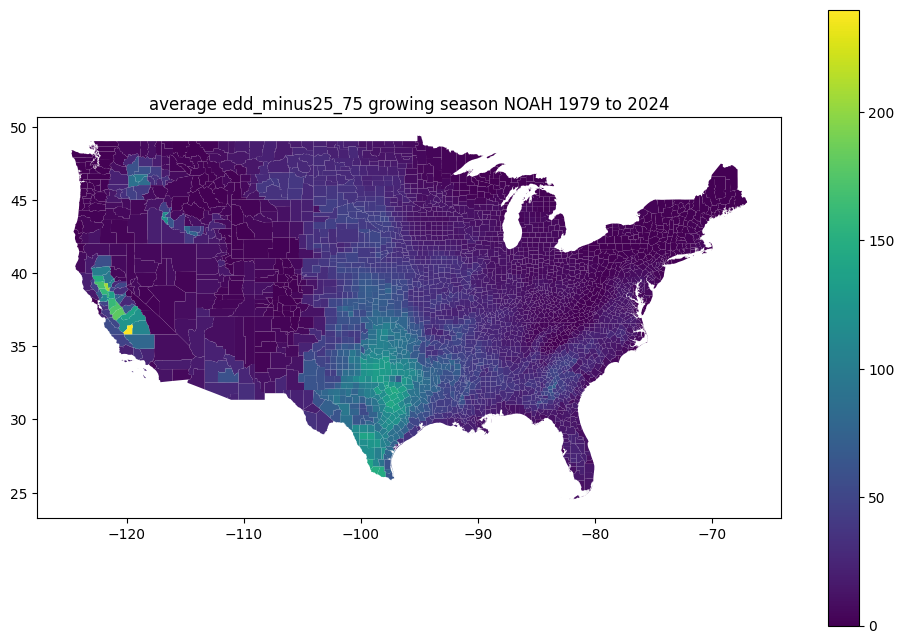

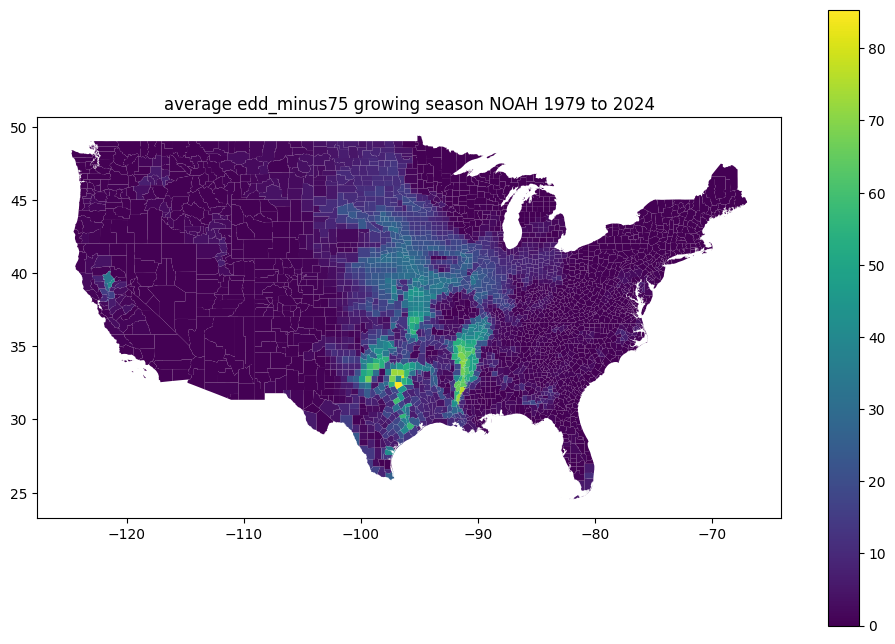

In [21]:
fips_mean = ds_out.groupby(level=['fips']).mean()
merged_gdf = us_county.merge(fips_mean, on='fips')
merged_gdf_nonnan = merged_gdf.dropna()
fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf_nonnan.plot(column='SoilM_0_100cm_square', cmap='viridis', linewidth=0.8, legend=True, ax=ax)
ax.set_title(f'average soilm^2 growing season {model} 1979 to 2024')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf_nonnan.plot(column='SoilM_0_100cm', cmap='viridis', linewidth=0.8, legend=True, ax=ax)
ax.set_title(f'average soilm growing season {model} 1979 to 2024')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf_nonnan.plot(column='gdd', cmap='viridis', linewidth=0.8, legend=True, ax=ax)
ax.set_title(f'average gdd growing season {model} 1979 to 2024')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf_nonnan.plot(column='edd_plus75', cmap='viridis', linewidth=0.8, legend=True, ax=ax)
ax.set_title(f'average edd_plus75 growing season {model} 1979 to 2024')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf_nonnan.plot(column='edd_plus25_75', cmap='viridis', linewidth=0.8, legend=True, ax=ax)
ax.set_title(f'average edd_plus25_75 growing season {model} 1979 to 2024')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf_nonnan.plot(column='edd_minus25_plus25', cmap='viridis', linewidth=0.8, legend=True, ax=ax)
ax.set_title(f'average edd_minus25_plus25 growing season {model} 1979 to 2024')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf_nonnan.plot(column='edd_minus25_75', cmap='viridis', linewidth=0.8, legend=True, ax=ax)
ax.set_title(f'average edd_minus25_75 growing season {model} 1979 to 2024')
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
merged_gdf_nonnan.plot(column='edd_minus75', cmap='viridis', linewidth=0.8, legend=True, ax=ax)
ax.set_title(f'average edd_minus75 growing season {model} 1979 to 2024')
plt.show()
